<a href="https://colab.research.google.com/github/Enigmatik100/Sentiment_Analysis_ProjectL3IA/blob/master/Projet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPSA: Conception et implémentation d’un algorithme d’analyse de sentiment basé sur les aspects

# Analyse des sentiments du jeu de données sur les restaurants et les ordinateurs.

## Objectif 1: calculer la polarité des mots dans les deux jeux de données à l’aide d’un lexicon de sentiment.

#### importer les librairies utiles

In [151]:
import xml.etree.ElementTree as ETree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk

# disable warning about the use of custom tokenizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [152]:
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [153]:
from nltk import pos_tag
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

In [154]:
path = 'drive/MyDrive/SentimentAnalysis/data/'
path_train_file = path + 'Restaurants_Train.xml'
path_test_file = path + 'Restaurants_Test_Gold.xml'
path_test_nolabel_file = path + 'Restaurants_Test_NoLabels.xml'

In [155]:
def xml_to_df(path):
  """
  Take a path to xml file and return it content as pandas dataframe
  args: path (path to xml file)
  return: panda dataframe 
  """
  
  columns = ['id', 'text', 'aspectTerm', 'from', 'to', 'aspectPolarity' ]
  all_items = []
  row = []
  pstree = ETree.parse(path)
  root = pstree.getroot() # the root of xml file 
  for sentence in root.iter('sentence'): # get the all sentences and for each sentence
    id = sentence.attrib.get('id')       # get the id
    text = sentence.find('text').text    # get the text
    aspectTerms = sentence.find('aspectTerms') # get all aspect terms and loop through each aspect
    if aspectTerms is not None:               # don't take text without aspect term
      for aspect in aspectTerms:
        term = aspect.attrib.get('term')      # get term
        polarity = aspect.attrib.get('polarity') # get polarity
        # print(f"id = {id} term = {term} - polarity= {polarity}")
        _from = aspect.attrib.get('from')   # get the start point
        to = aspect.attrib.get('to')      # get the end point
        row = [id, text, term, _from, to, polarity] # create the row of the dataframe
        all_items.append(row)                       # append the row to the list of all row
  return pd.DataFrame(all_items, columns = columns)


In [156]:
train_df = xml_to_df(path_train_file) # create the training df
test_df = xml_to_df(path_test_file)   # cretae test_df 

In [157]:
test_df.head(5)

,id,text,aspectTerm,from,to,aspectPolarity
0,813,"All the appetizers and salads were fabulous, t...",appetizers,8,18,positive
1,813,"All the appetizers and salads were fabulous, t...",salads,23,29,positive
2,813,"All the appetizers and salads were fabulous, t...",steak,49,54,positive
3,813,"All the appetizers and salads were fabulous, t...",pasta,82,87,positive
4,1579,And really large portions.,portions,17,25,positive


In [158]:
test_df_nolabel = xml_to_df(path_test_nolabel_file) #create the nolabel xml data frame
test_df_nolabel 

,id,text,aspectTerm,from,to,aspectPolarity
0,813,"All the appetizers and salads were fabulous, t...",appetizers,8,18,
1,813,"All the appetizers and salads were fabulous, t...",salads,23,29,
2,813,"All the appetizers and salads were fabulous, t...",steak,49,54,
3,813,"All the appetizers and salads were fabulous, t...",pasta,82,87,
4,1579,And really large portions.,portions,17,25,
...,...,...,...,...,...,...
91,2912,"The dishes offered were unique, very tasty and...",sardines with biscuits,77,99,
92,2912,"The dishes offered were unique, very tasty and...",large whole shrimp,101,119,
93,2912,"The dishes offered were unique, very tasty and...",pistachio ice cream,135,154,
94,3188,Went there for an office lunch.,office lunch,18,30,


Visualisons la proportion des différentes classes à prédire dans les données d'entrainement et de test.

Nous avons créé un data frame afin de nous faciliter la visualisation.
En effet, on compte le nombre d'occurence de chacune des polarités dans notre jeu de données. On normalize pour avoir des proportions, ensuite on muliplie par 100 pour que ces valeurs soient sous forme de pourcentage.

In [159]:
train_label_class_prop = train_df['aspectPolarity'].value_counts(normalize=True).mul(100).round(2).rename_axis('aspectPolarity').reset_index(name='TRAIN')
test_label_class_prop = test_df['aspectPolarity'].value_counts(normalize=True).mul(100).round(2).rename_axis('aspectPolarity').reset_index(name='TEST')

In [160]:
train_label_class_prop

,aspectPolarity,TRAIN
0,positive,58.60
1,negative,21.80
2,neutral,17.14
3,conflict,2.46


Dans les données d'entrainement, nous avons comme polarité pour les aspectTerms:


*   Positive: **58,60%**
*   Negative: **21,80%**
*   Neutral : **17,14%**
*   Conflict: **02,46%**





In [161]:
test_label_class_prop

,aspectPolarity,TEST
0,positive,70.83
1,negative,18.75
2,neutral,10.42


Dans les données de test, nous avons comme polarité pour les aspectTerms:


*   Positive: **70,83%**
*   Negative: **18,75%**
*   Neutral : **10,42%**


Les données de test ne contiennent aucune donnée de la classe **conflict**. 

Visualisons la répartition des proportions des différentes classes dans les données d'entrainement et de test

In [162]:
merge_df = pd.merge(train_label_class_prop, test_label_class_prop, on="aspectPolarity", how='left').set_index("aspectPolarity")

In [163]:
# en mergeant la ligne conflict n'étant pas présent dans les données de test, pandas remplit l'intersection de cette ligne et de cette column par NaN. 
# on remplace donc le NaN par 0 dans notre cas.
merge_df['TEST'].fillna(0, inplace=True) 

<Axes: xlabel='aspectPolarity'>

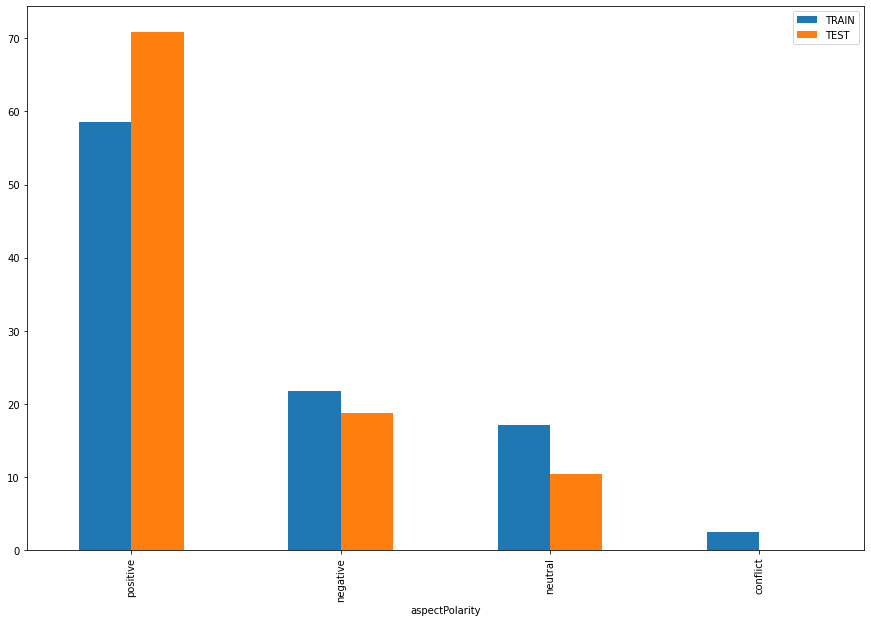

In [164]:
merge_df.plot.bar(figsize=(15, 10))

Dans l'énoncé du TP, il nous ai demandé de ne pas tenir compte de la polarité conflict. Nous allons supprimer les lignes ayant une polarité conflictuelle et visualiser une fois encore la répartition des différentes classes dans nos dataframes.

In [169]:
# remove all row with conflict polarity
train_df = train_df[train_df['aspectPolarity'] != 'conflict']

In [170]:
train_clean_label_class_prop = train_df['aspectPolarity'].value_counts(normalize=True).mul(100).round(2).rename_axis('aspectPolarity').reset_index(name='TRAIN')
test_label_class_prop = test_df['aspectPolarity'].value_counts(normalize=True).mul(100).round(2).rename_axis('aspectPolarity').reset_index(name='TEST')
merge_df2 = pd.merge(train_clean_label_class_prop, test_label_class_prop, on="aspectPolarity", how='left').set_index("aspectPolarity")

In [171]:
merge_df2

,TRAIN,TEST
aspectPolarity,,
positive,60.08,70.83
negative,22.35,18.75
neutral,17.57,10.42


<Axes: xlabel='aspectPolarity'>

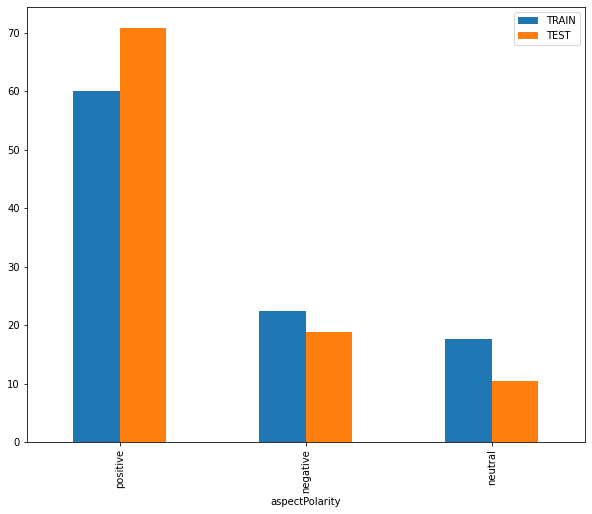

In [172]:
merge_df2.plot.bar(figsize=(10, 8))

Comme on peut le constater, nous sommes dans un cas où notre jeu de données n'est pas équilibré. La proportion des différentes classes n'est pas la même dans les différents jeu de données.

### Tokenizer, PoS Tagger, NER

Nous n'avons effectué aucun pré-traitement à nos données avant de tokeniser, d'identifier les part of speech et les Ner pour ne pas biaiser les données

In [173]:
train_df['tokens'] = train_df['text'].apply(word_tokenize)  # tokenize all values in column text
train_df['posTag'] = train_df['tokens'].apply(pos_tag)  # identity part of speech for each token in sentence
train_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag
0,3121,But the staff was so horrible to us.,staff,8,13,negative,"[But, the, staff, was, so, horrible, to, us, .]","[(But, CC), (the, DT), (staff, NN), (was, VBD)..."
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive,"[To, be, completely, fair, ,, the, only, redee...","[(To, TO), (be, VB), (completely, RB), (fair, ..."
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,..."
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,..."
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,..."
...,...,...,...,...,...,...,...,...
3688,671,Each table has a pot of boiling water sunken i...,pot of boiling water,17,37,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),..."
3689,671,Each table has a pot of boiling water sunken i...,meats,99,104,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),..."
3690,671,Each table has a pot of boiling water sunken i...,vegetables,114,124,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),..."
3691,671,Each table has a pot of boiling water sunken i...,rice,130,134,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),..."


In [174]:
test_df['tokens'] = test_df['text'].apply(word_tokenize) 
test_df['posTag'] = test_df['tokens'].apply(pos_tag) 
test_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag
0,813,"All the appetizers and salads were fabulous, t...",appetizers,8,18,positive,"[All, the, appetizers, and, salads, were, fabu...","[(All, PDT), (the, DT), (appetizers, NNS), (an..."
1,813,"All the appetizers and salads were fabulous, t...",salads,23,29,positive,"[All, the, appetizers, and, salads, were, fabu...","[(All, PDT), (the, DT), (appetizers, NNS), (an..."
2,813,"All the appetizers and salads were fabulous, t...",steak,49,54,positive,"[All, the, appetizers, and, salads, were, fabu...","[(All, PDT), (the, DT), (appetizers, NNS), (an..."
3,813,"All the appetizers and salads were fabulous, t...",pasta,82,87,positive,"[All, the, appetizers, and, salads, were, fabu...","[(All, PDT), (the, DT), (appetizers, NNS), (an..."
4,1579,And really large portions.,portions,17,25,positive,"[And, really, large, portions, .]","[(And, CC), (really, RB), (large, JJ), (portio..."
...,...,...,...,...,...,...,...,...
91,2912,"The dishes offered were unique, very tasty and...",sardines with biscuits,77,99,positive,"[The, dishes, offered, were, unique, ,, very, ...","[(The, DT), (dishes, NNS), (offered, VBN), (we..."
92,2912,"The dishes offered were unique, very tasty and...",large whole shrimp,101,119,positive,"[The, dishes, offered, were, unique, ,, very, ...","[(The, DT), (dishes, NNS), (offered, VBN), (we..."
93,2912,"The dishes offered were unique, very tasty and...",pistachio ice cream,135,154,positive,"[The, dishes, offered, were, unique, ,, very, ...","[(The, DT), (dishes, NNS), (offered, VBN), (we..."
94,3188,Went there for an office lunch.,office lunch,18,30,neutral,"[Went, there, for, an, office, lunch, .]","[(Went, NN), (there, EX), (for, IN), (an, DT),..."


In [175]:

def penn_to_wn(tag):
  """Convertion des tags en simple WORDNET TAGS"""
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB
  return None

lemmatizer = WordNetLemmatizer()
def get_sentiment(word,tag):
  """
  Return une liste de score positif negatif ou neutre et return une liste vide si le mo
  """
  wn_tag = penn_to_wn(tag)
  if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
    return []
  lemma = lemmatizer.lemmatize(word, pos=wn_tag)
  if not lemma:
    return []
  synsets = wn.synsets(word, pos=wn_tag)
  if not synsets:
    return []
  # Prend le premier sens du mot c'est à dire le sens le plus commun
  synset = synsets[0]
  swn_synset= swn.senti_synset(synset.name())
  return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [176]:
# this function will be use to the part of speech column we create, and will help us to get sentiment of every token of a sentence if this token is noun, adj or adv
def get_polarity(x):
  return [get_sentiment(word, tag) for (word, tag) in x]

In [177]:
train_df['word_polarity'] = train_df['posTag'].apply(get_polarity)  #  apply this function to pos tag column we create below


In [178]:
train_df['word_polarity']

0       [[], [], [0.0, 0.0, 1.0], [], [0.0, 0.0, 1.0],...
1       [[], [], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375],...
2       [[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....
3       [[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....
4       [[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....
                              ...                        
3688    [[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...
3689    [[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...
3690    [[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...
3691    [[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...
3692    [[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...
Name: word_polarity, Length: 3602, dtype: object

In [179]:
from nltk import ne_chunk


In [27]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 3.7 MB/s eta 0:00:00


[('European', 'JJ'), ('authorities', 'NNS'), ('fined', 'VBD'), ('Google', 'NNP'), ('a', 'DT'), ('record', 'NN'), ('$', '$'), ('5.1', 'CD'), ('billion', 'CD'), ('on', 'IN'), ('Wednesday', 'NNP'), ('for', 'IN'), ('abusing', 'VBG'), ('its', 'PRP$'), ('power', 'NN'), ('in', 'IN'), ('the', 'DT'), ('mobile', 'JJ'), ('phone', 'NN'), ('market', 'NN'), ('and', 'CC'), ('ordered', 'VBD'), ('the', 'DT'), ('company', 'NN'), ('to', 'TO'), ('alter', 'VB'), ('its', 'PRP$'), ('practices', 'NNS'), ('.', '.')]


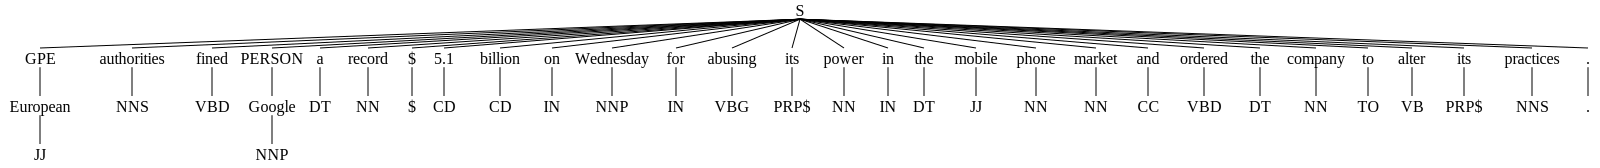

In [28]:
def detect_ner(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    print(pos_tags)
    ner_tags = ne_chunk(pos_tags)
    return ner_tags

text = "European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices."
detect_ner(text)

In [180]:
train_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag,word_polarity
0,3121,But the staff was so horrible to us.,staff,8,13,negative,"[But, the, staff, was, so, horrible, to, us, .]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[[], [], [0.0, 0.0, 1.0], [], [0.0, 0.0, 1.0],..."
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive,"[To, be, completely, fair, ,, the, only, redee...","[(To, TO), (be, VB), (completely, RB), (fair, ...","[[], [], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375],..."
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
...,...,...,...,...,...,...,...,...,...
3688,671,Each table has a pot of boiling water sunken i...,pot of boiling water,17,37,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3689,671,Each table has a pot of boiling water sunken i...,meats,99,104,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3690,671,Each table has a pot of boiling water sunken i...,vegetables,114,124,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3691,671,Each table has a pot of boiling water sunken i...,rice,130,134,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."


## Objectif 2 : Determiner la polarité des termes des aspects

### Entrainer un modele de machine learning

Nous avons testé trois modèle à savoir: 


*   Logistic Regression
*   Support Vector Classifier
*   Multinomial Naive Bayes



In [30]:
import re
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [181]:
X_train = train_df['text']
y_train = train_df['aspectPolarity']

In [32]:
X_test = test_df['text']
y_test = test_df['aspectPolarity']

Afin d'entrainer un modèle de machine learning, nous avons défini tokenizer personnalisé.

In [33]:
# Define pre-treatement for every text before tokenization

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')  # some special character are replace by space
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]') # remove bad symbol
STOPWORDS = set(stopwords.words('english'))  # english stop words

def clean_text(text):
  text = text.lower()
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
  text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
  token_without_sw = [word for word in word_tokenize(text) if word is not STOPWORDS]
  return ' '.join(token_without_sw)

# Define a custom tokenizer
class MyTokenizer:
    def __call__(self, doc):
        return [clean_text(t) for t in word_tokenize(doc)]


In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline


#### Regression logistic

In [35]:
# I define the pipeline
lg = Pipeline([
        ('vectorizer',  TfidfVectorizer(tokenizer=MyTokenizer(), ngram_range=(1,3), stop_words='english')),
        ('logistic_regresssion',  LogisticRegression(max_iter=1000, multi_class="multinomial"))
        ])
parameters = {}

# Les différentes valeurs du paramètre C à tester
parameters['logistic_regresssion__C'] = [ 0.001, 0.01, 0.1, 1, 10, 100]

# GridSearch CV pour trouver le paramètre C de la regression qui nous donne les meilleures performances en utilisant la 5-folds validation
grid = GridSearchCV(lg, parameters, scoring='accuracy', cv=5, verbose=2,n_jobs=None)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................logistic_regresssion__C=0.001; total time=  11.8s
[CV] END ......................logistic_regresssion__C=0.001; total time=  16.1s
[CV] END ......................logistic_regresssion__C=0.001; total time=   8.6s
[CV] END ......................logistic_regresssion__C=0.001; total time=   5.9s
[CV] END ......................logistic_regresssion__C=0.001; total time=   5.2s
[CV] END .......................logistic_regresssion__C=0.01; total time=   7.8s
[CV] END .......................logistic_regresssion__C=0.01; total time=   5.4s
[CV] END .......................logistic_regresssion__C=0.01; total time=   7.7s
[CV] END .......................logistic_regresssion__C=0.01; total time=   5.4s
[CV] END .......................logistic_regresssion__C=0.01; total time=   7.3s
[CV] END ........................logistic_regresssion__C=0.1; total time=   6.3s
[CV] END ........................logistic_regress

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 3),
                                                        stop_words='english',
                                                        tokenizer=<__main__.MyTokenizer object at 0x7fb3ad26f940>)),
                                       ('logistic_regresssion',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             param_grid={'logistic_regresssion__C': [0.001, 0.01, 0.1, 1, 10,
                                                     100]},
             scoring='accuracy', verbose=2)

In [36]:
grid.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [37]:
grid.best_estimator_  # contain the train model with the best parameter

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 tokenizer=<__main__.MyTokenizer object at 0x7fb3ad3cb100>)),
                ('logistic_regresssion',
                 LogisticRegression(C=10, max_iter=1000,
                                    multi_class='multinomial'))])

Le paramètre donnant la meilleure performance ici c'est **C = 10**

In [38]:
grid.best_params_

{'logistic_regresssion__C': 10}

In [39]:
# get the best accuracy
grid.best_score_

0.6862860224996148

In [40]:
# make prediction on test dataset
y_pred = grid.predict(X_test)

In [41]:
# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)

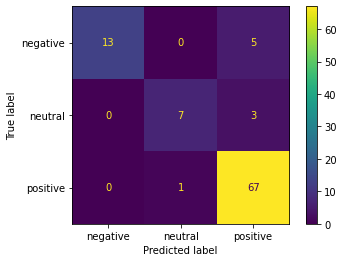

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=grid.classes_)
disp.plot()
plt.show()

In [43]:
# resume all metrics together
print(classification_report(y_test, y_pred, target_names=grid.classes_))

              precision    recall  f1-score   support

    negative       1.00      0.72      0.84        18
     neutral       0.88      0.70      0.78        10
    positive       0.89      0.99      0.94        68

    accuracy                           0.91        96
   macro avg       0.92      0.80      0.85        96
weighted avg       0.91      0.91      0.90        96



#### SVC

In [ ]:
from sklearn.svm import SVC

svc = Pipeline([
        ('vectorizer',  TfidfVectorizer(tokenizer=MyTokenizer(), ngram_range=(1,3), stop_words='english')),
        ('svc',  SVC())
        ])
parameters = {}


  
# defining parameter range
param_grid = {'svc__C': [0.1, 1, 10, 100], 
              'svc__gamma': [1, 0.1, 0.01, 0.001],
              'svc__kernel': ['rbf', 'poly']
              } 
  
svc_grid = GridSearchCV(svc, param_grid,  cv=5, verbose = 3, n_jobs=None)
  
# fitting the model for grid search
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf;, score=0.601 total time=   9.0s
[CV 2/5] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf;, score=0.601 total time=   7.3s
[CV 3/5] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf;, score=0.601 total time=   8.6s
[CV 4/5] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf;, score=0.601 total time=   6.9s
[CV 5/5] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf;, score=0.600 total time=   8.7s
[CV 1/5] END svc__C=0.1, svc__gamma=1, svc__kernel=poly;, score=0.601 total time=   7.0s
[CV 2/5] END svc__C=0.1, svc__gamma=1, svc__kernel=poly;, score=0.601 total time=   8.9s
[CV 3/5] END svc__C=0.1, svc__gamma=1, svc__kernel=poly;, score=0.601 total time=   6.9s
[CV 4/5] END svc__C=0.1, svc__gamma=1, svc__kernel=poly;, score=0.601 total time=   8.9s
[CV 5/5] END svc__C=0.1, svc__gamma=1, svc__kernel=poly;, score=0.600 total time=   7.8s
[CV 1/5] END svc__C=0.1, svc__gamma=0.1, svc__kernel=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 3),
                                                        stop_words='english',
                                                        tokenizer=<__main__.MyTokenizer object at 0x7fa0986b3310>)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['rbf', 'poly']},
             verbose=3)

In [ ]:
svc_grid.best_score_

0.6785182616736014

On obtient un accuracy de **67,85%**

In [ ]:
svc_grid.best_estimator_

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 tokenizer=<__main__.MyTokenizer object at 0x7fa097ce4d30>)),
                ('svc', SVC(C=100, gamma=0.1))])

In [ ]:
# get best params
svc_grid.best_params_

{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

In [ ]:
y_pred = svc_grid.predict(X_test)
print(classification_report(y_test, y_pred, target_names=svc_grid.classes_))

              precision    recall  f1-score   support

    negative       0.93      0.78      0.85        18
     neutral       0.80      0.80      0.80        10
    positive       0.92      0.96      0.94        68

    accuracy                           0.91        96
   macro avg       0.88      0.84      0.86        96
weighted avg       0.91      0.91      0.90        96



### Naive Bayes Classifier

In [49]:
from sklearn.naive_bayes import MultinomialNB

nb_pipe = Pipeline([        
    ('vect',  TfidfVectorizer(tokenizer=MyTokenizer(), stop_words='english')),
    ('nb', MultinomialNB()),
])

# parameter tuning with grid search
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],  
              'nb__alpha': ( 0.022,0.025, 0.028),
}
nb_grid = GridSearchCV(nb_pipe, parameters,n_jobs=None, verbose=2,cv=5)
nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 1); total time=   6.7s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 1); total time=   5.2s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 1); total time=   4.9s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 1); total time=   7.0s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 1); total time=   4.9s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 2); total time=   6.3s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 2); total time=   7.0s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 2); total time=   5.3s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 2); total time=   7.7s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 2); total time=   5.0s
[CV] END ..........nb__alpha=0.022, vect__ngram_range=(1, 3); total time=   7.1s
[CV] END ..........nb__alpha=0.022, vect__ngram_r

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        tokenizer=<__main__.MyTokenizer object at 0x7fb3ac15eaf0>)),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': (0.022, 0.025, 0.028),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=2)

In [51]:
nb_grid.best_estimator_  # contain the train model with the best parameter

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<__main__.MyTokenizer object at 0x7fb3bd415e80>)),
                ('nb', MultinomialNB(alpha=0.025))])

In [53]:
# get the best accuracy
nb_grid.best_score_

0.6465865310525505

On obtient un accuracy de **64,65%**

In [54]:
y_pred = grid.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred, target_names=nb_grid.classes_))

              precision    recall  f1-score   support

    negative       1.00      0.72      0.84        18
     neutral       0.88      0.70      0.78        10
    positive       0.89      0.99      0.94        68

    accuracy                           0.91        96
   macro avg       0.92      0.80      0.85        96
weighted avg       0.91      0.91      0.90        96



**Au total, La regression logistique est le modèle qui nous donne la meilleure performance.**





### Approche basé sur les règles

Dans notre approche basée sur des règles, nous identifions l'aspect term, ensuite nous essayons d'identifier s'il se retrouve dans un des pattern suivants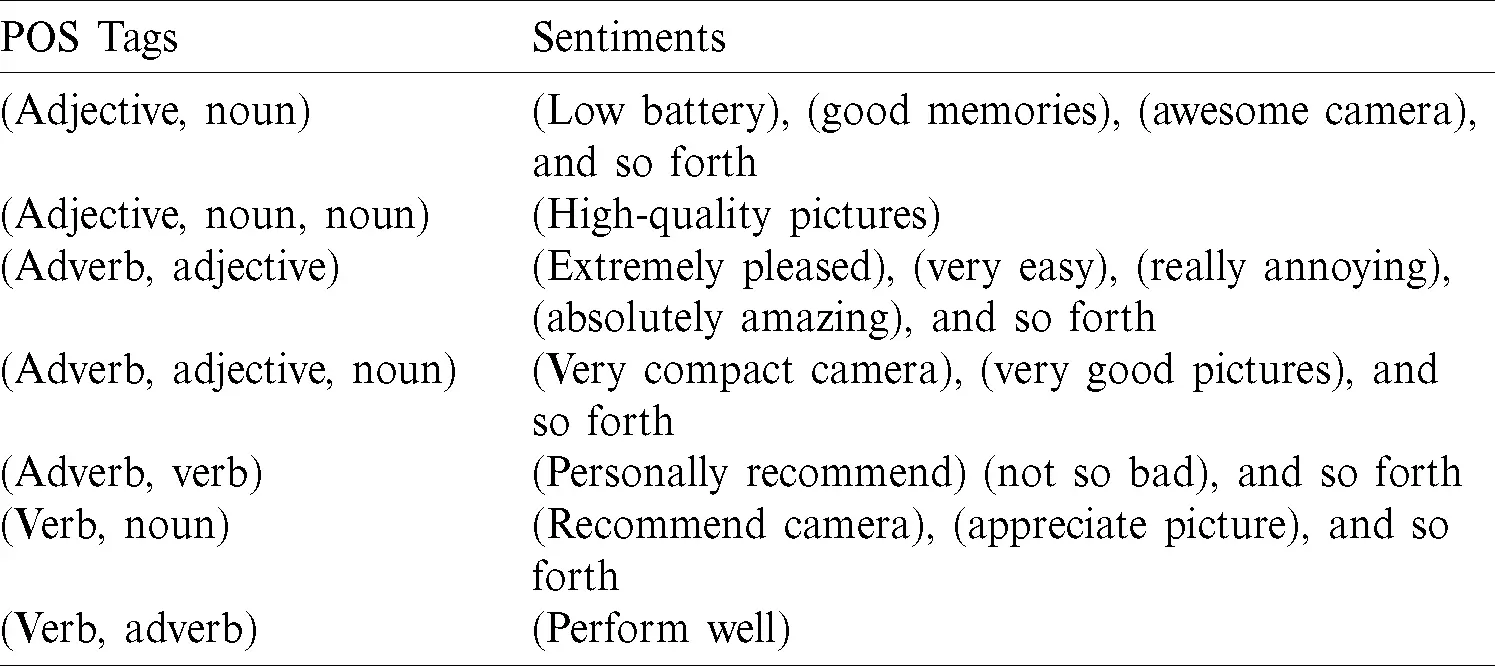

**('ADJ-NN', 'ADJ-NN-NN', 'ADJ-ADJ', 'ADV-ADJ-NN', 'ADV-VB', 'VB-NN', 'VB-ADV')**

On se basera ensuite sur la polarité des éléments autour de l'aspect pour attribuer une polarité à cet aspect.

In [57]:
train_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag,word_polarity
0,3121,But the staff was so horrible to us.,staff,8,13,negative,"[But, the, staff, was, so, horrible, to, us, .]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[[], [], [0.0, 0.0, 1.0], [], [0.0, 0.0, 1.0],..."
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive,"[To, be, completely, fair, ,, the, only, redee...","[(To, TO), (be, VB), (completely, RB), (fair, ...","[[], [], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375],..."
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0...."
...,...,...,...,...,...,...,...,...,...
3688,671,Each table has a pot of boiling water sunken i...,pot of boiling water,17,37,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3689,671,Each table has a pot of boiling water sunken i...,meats,99,104,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3690,671,Each table has a pot of boiling water sunken i...,vegetables,114,124,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."
3691,671,Each table has a pot of boiling water sunken i...,rice,130,134,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],..."


In [182]:
def get_sentiment_token(pos_tags):
  # get only token with tag Noun, adjective, adverd or verb
  return [pos_tag for pos_tag in pos_tags if penn_to_wn(pos_tag[1]) in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB)]

train_df['sentiment_word'] = train_df['posTag'].apply(get_sentiment_token)

In [183]:
def get_token_polarity(word, tag):
  """
  return the dominant polarity for this token
  """
  wn_tag = penn_to_wn(tag)
  if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
    return None
  lemma = lemmatizer.lemmatize(word, pos=wn_tag)
  if not lemma:
    return None
  synsets = wn.synsets(word, pos=wn_tag)
  if not synsets:
    return None
  
  synset = synsets[0]
  swn_synset= swn.senti_synset(synset.name())
  polarities= [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]
  max_index = np.argmax(polarities)
  if max_index == 0:
    return 1 # 'positive'
  elif max_index == 1:
    return -1 # 'negative'
  else:
    return 0  # 'neutral'

def func_get_token_polarity(x):
  res = [get_token_polarity(word, tag) for (word, tag) in x]
  return [v for v in res if v is not None]

In [184]:
train_df['token_polarites'] = train_df['posTag'].apply(func_get_token_polarity)

In [185]:
train_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag,word_polarity,sentiment_word,token_polarites
0,3121,But the staff was so horrible to us.,staff,8,13,negative,"[But, the, staff, was, so, horrible, to, us, .]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[[], [], [0.0, 0.0, 1.0], [], [0.0, 0.0, 1.0],...","[(staff, NN), (was, VBD), (so, RB), (horrible,...","[0, 0, 0, -1]"
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive,"[To, be, completely, fair, ,, the, only, redee...","[(To, TO), (be, VB), (completely, RB), (fair, ...","[[], [], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375],...","[(be, VB), (completely, RB), (fair, JJ), (only...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]"
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]"
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]"
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]"
...,...,...,...,...,...,...,...,...,...,...,...
3688,671,Each table has a pot of boiling water sunken i...,pot of boiling water,17,37,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3689,671,Each table has a pot of boiling water sunken i...,meats,99,104,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3690,671,Each table has a pot of boiling water sunken i...,vegetables,114,124,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3691,671,Each table has a pot of boiling water sunken i...,rice,130,134,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [186]:
def predict_polarity(x):
  s = sum(x)
  if s >= 1:
    return 1
  elif s <= -1:
    return -1
  else:
    return 0

In [187]:
train_df['predict_based_rule'] = train_df['token_polarites'].apply(predict_polarity)

In [188]:
# decode predict value to evaluate metrics
def decode(x):
  d = {1: 'positive', -1: 'negative', 0: 'neutral'}
  return d[x]

In [189]:
train_df['predict_based_rule'] = train_df['predict_based_rule'].apply(decode)

In [190]:
print(classification_report(train_df['aspectPolarity'], train_df['predict_based_rule'], target_names=grid.classes_))

              precision    recall  f1-score   support

    negative       0.41      0.36      0.39       805
     neutral       0.23      0.53      0.32       633
    positive       0.76      0.51      0.61      2164

    accuracy                           0.48      3602
   macro avg       0.47      0.47      0.44      3602
weighted avg       0.59      0.48      0.51      3602



Comme on peut s'y attendre la baseline de l'approche basée sur les règles ne donne pas de bonne performance.

Essayons une approche basée sur de règles en utilisant les tokens exprimant un sentiment à savoir: verbe, adjectifs, noun, et les adverbes

In [200]:
# ('ADJ-NN', 'ADJ-NN-NN', 'ADJ-ADJ', 'ADV-ADJ-NN', 'ADV-VB', 'VB-NN', 'VB-ADV')
patterns = [(wn.ADJ,wn.NOUN), (wn.ADJ,wn.NOUN,wn.NOUN), (wn.ADJ,wn.ADJ),(wn.ADV,wn.ADJ, wn.NOUN), (wn.ADV, wn.VERB), (wn.VERB, wn.NOUN), (wn.VERB, wn.ADV)]

In [221]:
def get_term_index_from_sentiment_word(term, sentiment_word):
  for i in range(len(sentiment_word)):
    w, t = sentiment_word[i]
    if w == term:
      return i
  return -1


def get_polarity_using_pattern(row):
  text = row['text']
  term = row['aspectTerm']
  tokens = row['tokens']
  sentiment_words = row['sentiment_word'] # we work with only sentiment token

  if len(sentiment_words) == 1:
    return [get_token_polarity(*sentiment_words[0])]
  elif len(sentiment_words) == 2:
        term_index = get_term_index_from_sentiment_word(term, sentiment_words)
        if term_index == - 1:
          return [get_token_polarity(*sentiment_words[0]) ,get_token_polarity(*sentiment_words[1])]
        else:
          if term_index == 0:
            return [get_token_polarity(*sentiment_words[1])]
          else:
            return [get_token_polarity(*sentiment_words[0])]
  elif len(sentiment_words) > 2:
    term_index = get_term_index_from_sentiment_word(term, sentiment_words)
    if term_index == -1:
      return [get_token_polarity(*w) for w in sentiment_words]
    elif term_index == 0:
      return [get_token_polarity(*sentiment_words[1])]
    elif term_index == len(sentiment_words) -1:
      return [get_token_polarity(*sentiment_words[-2])]
    else:
      term = sentiment_words[term_index]
      prev = sentiment_words[term_index - 1]
      next = sentiment_words[term_index + 1]
      prev_tag, term_tag, next_tag = penn_to_wn(prev[1]),  penn_to_wn(term[1]), penn_to_wn(next[1])
      if (prev_tag, term_tag) in patterns or (term_tag, next_tag) in patterns: # identify one the pattern we define
        return [get_token_polarity(*prev), get_token_polarity(*next)]
      else:
        return [get_token_polarity(*w) for w in sentiment_words]

train_df['polarity_using_pattern'] = train_df.apply(get_polarity_using_pattern, axis=1)

In [225]:
def func_get_token_polarity_using_pattern(x):
  d = {1: 'positive', -1: 'negative', 0: 'neutral'}
  s = sum([v for v in x if v is not None])

  if s >= 1:
    c = 1
  elif s <= -1:
    c = -1
  else:
    c = 0
  return d[c]

train_df['pred_polarity_using_pattern'] = train_df['polarity_using_pattern'].apply(func_get_token_polarity_using_pattern)

In [226]:

train_df

,id,text,aspectTerm,from,to,aspectPolarity,tokens,posTag,word_polarity,sentiment_word,token_polarites,predict_based_rule,polarity_using_pattern,pred_polarity_using_pattern
0,3121,But the staff was so horrible to us.,staff,8,13,negative,"[But, the, staff, was, so, horrible, to, us, .]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[[], [], [0.0, 0.0, 1.0], [], [0.0, 0.0, 1.0],...","[(staff, NN), (was, VBD), (so, RB), (horrible,...","[0, 0, 0, -1]",negative,[0],neutral
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive,"[To, be, completely, fair, ,, the, only, redee...","[(To, TO), (be, VB), (completely, RB), (fair, ...","[[], [], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375],...","[(be, VB), (completely, RB), (fair, JJ), (only...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]",positive,"[0, 0]",neutral
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]",negative,[0],neutral
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]",negative,"[0, 0]",neutral
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral,"[The, food, is, uniformly, exceptional, ,, wit...","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[[], [0.0, 0.0, 1.0], [], [], [0.25, 0.125, 0....","[(food, NN), (is, VBZ), (uniformly, JJ), (exce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]",negative,"[None, -1]",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3688,671,Each table has a pot of boiling water sunken i...,pot of boiling water,17,37,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
3689,671,Each table has a pot of boiling water sunken i...,meats,99,104,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral,"[0, 0]",neutral
3690,671,Each table has a pot of boiling water sunken i...,vegetables,114,124,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral,"[0, 0]",neutral
3691,671,Each table has a pot of boiling water sunken i...,rice,130,134,neutral,"[Each, table, has, a, pot, of, boiling, water,...","[(Each, DT), (table, NN), (has, VBZ), (a, DT),...","[[], [0.0, 0.0, 1.0], [], [], [0.0, 0.0, 1.0],...","[(table, NN), (has, VBZ), (pot, NN), (boiling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral


In [227]:
print(classification_report(train_df['aspectPolarity'], train_df['pred_polarity_using_pattern'], target_names=nb_grid.classes_))

              precision    recall  f1-score   support

    negative       0.42      0.22      0.29       805
     neutral       0.21      0.73      0.32       633
    positive       0.78      0.35      0.48      2164

    accuracy                           0.39      3602
   macro avg       0.47      0.43      0.36      3602
weighted avg       0.60      0.39      0.41      3602



Notre approche basé sur des règles n'est pas assez performant non plus.

Au terme de ce projet, nous avons découvert une nouvelle forme d'analyse de sentiment qui est l'analyse des sentiments basé sur les aspects.
Cette forme d'analyse de sentiment est un peu plus pertinente que les cas qu'on rencontre habituellement.
La grande difficulté pour nous dans ce  projet a été de savoir comment tiré profit, des pos tagger, Ner et sentiwordnet afin d'améliorer les performances de notre modèle pour l'approche utilisant le machine learning.
Nous avons pu tout de même obtenu un modèle assez performant en utilsant que la colonne text. Ce qui en parti n'est pas très efficace d'autant plus que nous avons parfois deux polarités différentes pour des aspects différents dans une même phrase. Cela a du compromettre certaines lignes de données car c'est comme si c'est deux lignes se contredisaient.